In [2]:
!pip install sentence_transformers pinecone-client==3.1.0 datasets seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 27.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl

In [3]:
from datasets import load_dataset

df = load_dataset("ashraq/hotel-reviews", split="train").to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/93757 [00:00<?, ? examples/s]

In [4]:
df["review"] = df["review"].str[:800]

In [6]:
df


,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...
...,...,...,...
93752,8/4/2015,Holiday Inn London Kensington,Loved the location friendly helpful staff
93753,8/4/2015,Holiday Inn London Kensington,The room wasn t what was described on website...
93754,8/4/2015,Holiday Inn London Kensington,Location was good
93755,8/4/2015,Holiday Inn London Kensington,Bed room service was very late


In [5]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

In [8]:
model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [9]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [10]:
# view review number 241
test_review = df["review"][241]
test_review

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [11]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.7736576199531555}]

In [13]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
# it creates the vector embeddings that are 384 dimensional vectors
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [14]:
import os
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.environ.get('fd9f3bfe-cfe2-45fa-b96b-a0481ac9c51c') or 'fd9f3bfe-cfe2-45fa-b96b-a0481ac9c51c'

# configure client
pc = Pinecone(api_key=api_key)

In [15]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [16]:
index_name = "sentiment-mining"

In [17]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=384,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [18]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [19]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['negative', 'neutral', 'positive'],
 [0.9065253138542175, 0.7716172337532043, 0.8975034952163696])

In [20]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [21]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

In [22]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["review"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["review_date"].tolist())
    batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/1465 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
<ipython-input-22-85d5b138fbe4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-input-22-85d5b138fbe4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["score"] = score
<ipython-input-22-85d5b138fbe4>:15: SettingWithCopyWarning: 
A value is trying 

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 93696}},
 'total_vector_count': 93696}

In [23]:
query = "are the customers satisfied with the room sizes in London hotels?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

In [24]:
result["matches"][:2]

[{'id': '57268',
  'metadata': {'hotel_name': 'Millennium Gloucester Hotel London',
               'label': 'neutral',
               'review': ' The size of the room compared to other london hotels '
                         'And the location and friednly staff ',
               'review_date': '10/9/2015',
               'score': 0.7984868884086609,
               'timestamp': 1444348800.0},
  'score': 0.819273174,
  'values': []},
 {'id': '36931',
  'metadata': {'hotel_name': 'DoubleTree by Hilton London Docklands Riverside',
               'label': 'positive',
               'review': ' Rooms great but on the small size but typical for a '
                         'London hotel',
               'review_date': '11/8/2015',
               'score': 0.8672298192977905,
               'timestamp': 1446940800.0},
  'score': 0.817437887,
  'values': []}]

In [25]:
result["matches"][-2:]

[{'id': '28490',
  'metadata': {'hotel_name': 'Park Plaza London Riverbank',
               'label': 'positive',
               'review': ' Good size bedroom and bathroom for central london',
               'review_date': '3/15/2016',
               'score': 0.9178345799446106,
               'timestamp': 1458000000.0},
  'score': 0.64407891,
  'values': []},
 {'id': '39756',
  'metadata': {'hotel_name': 'Park Grand Paddington Court',
               'label': 'negative',
               'review': ' The room was very very small we did upgrade but '
                         'still very small and the hotel too expensive comare '
                         'to the room ',
               'review_date': '10/21/2016',
               'score': 0.5684893727302551,
               'timestamp': 1477008000.0},
  'score': 0.643892229,
  'values': []}]

In [26]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [27]:
sentiment = count_sentiment(result)
sentiment

{'negative': 58, 'neutral': 159, 'positive': 283}

<Axes: >

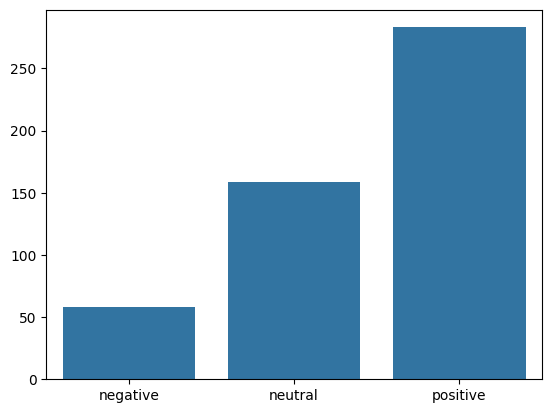

In [28]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

In [29]:
# generate timestamps for start and end time of the period
start_time = get_timestamp(["2015-12-25"])[0]
end_time = get_timestamp(["2015-12-31"])[0]

<Axes: >

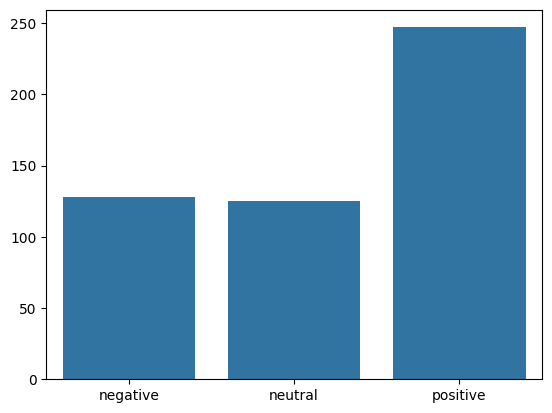

In [30]:
query = "are the customers satisified with the room sizes of hotels in London?"
# generate query embeddings
xq = retriever.encode(query).tolist()
# query pinecone with query embeddings and the period filter
result = index.query(
    vector=xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})
# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

In [31]:
hotels =[
    "Strand Palace Hotel",
    "Britannia International Hotel Canary Wharf",
    "Grand Royale London Hyde Park",
    "Intercontinental London The O2",
]

In [32]:
queries = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC"
}

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

hotel_sentiments = []

# iterate through the hotels
for hotel in hotels:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(vector=xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to result list
            result.append(data)
    # convert the
    hotel_sentiments.append({"hotel": hotel, "df": pd.DataFrame(result)})

In [34]:
hotel_sentiments[0]["df"]


,area,label,value
0,Room Size,negative,127
1,Room Size,neutral,187
2,Room Size,positive,186
3,Cleanliness,negative,88
4,Cleanliness,neutral,64
5,Cleanliness,positive,348
6,Staff,negative,70
7,Staff,neutral,36
8,Staff,positive,394
9,Food,negative,96


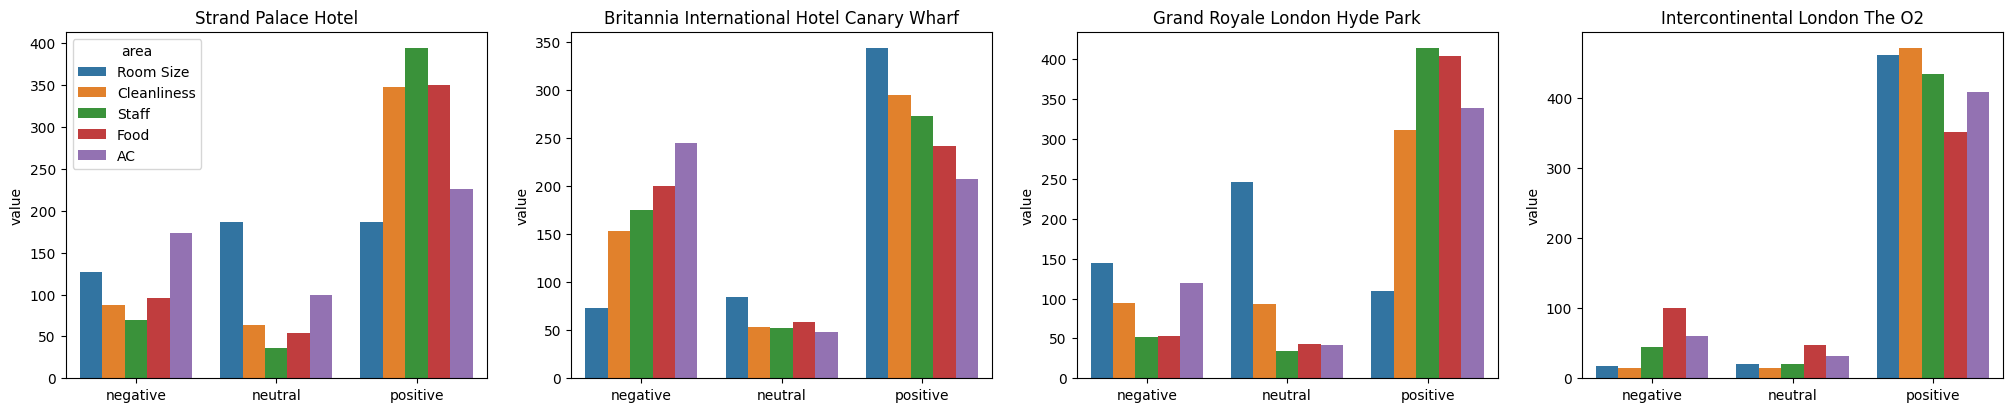

In [35]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0
# iterate through each hotel in the list and plot a barchart
for d, ax in zip(hotel_sentiments, axs.ravel()):
    # plot barchart for each hotel
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax)
    # display the hotel names
    ax.set_title(d["hotel"])
    # remove x labels
    ax.set_xlabel("")
    # remove legend from all charts except for the first one
    counter += 1
    if counter != 1: ax.get_legend().remove()
# display the full figure
plt.show()